In [11]:
import numpy as np
import qutip as qt
import scipy as sc
import matplotlib as mpl
import matplotlib.colors as cl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import itertools
mpl.rcParams.update({'font.size':20}) # This sometimes needs to be run twice to make it work
print (np.__version__)
print (sc.__version__)
import sys
ucl_lib_path = "/media/dustyd/08168c1d-108e-41ae-9add-9d5b218134e5/Documents/Repositories/ucl-measurement-code/LibModules"
sys.path.append(ucl_lib_path)
import physical_constants as pc

1.17.2
1.3.0


/home/dustyd/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


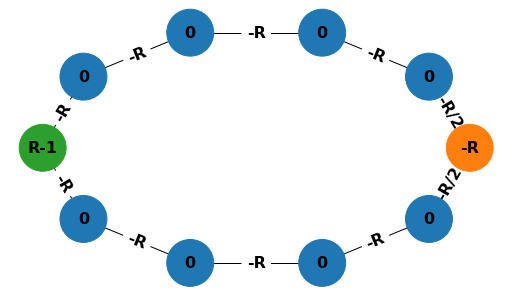

In [2]:
# Schedules
def A(t,p):
    if p["stype"] == "linear":
        if t < 0:
            return 1.0
        elif t >= 0 and t <= p["tan"]:
            return (1.0-t/p["tan"])
        else:
            return 0.0
def B(t,p):
    if p["stype"] == "linear":
        if t < 0:
            return 0.0
        elif t >= 0 and t <= p["tan"]:
            return (t/p["tan"])
        else:
            return 1.0

# Create loop gadget instance
class loop_gadget:
    def __init__(self,Nqb,R=1,hx_init=5,biased_qbs=2):
        self.Nqb = Nqb
        self.graph = nx.Graph()
        self.node_colors = []
        self.node_labels = {}
        
        # Create graph
        for qb in range(Nqb):
            self.graph.add_node(qb,hz=0,hx=hx_init)
            self.node_colors.append('C0')
            self.node_labels[qb] = '0'
        for e in range(Nqb):
            if e == Nqb-1:
                self.graph.add_edge(0,e,J=-R,desc="-R")
            else:
                self.graph.add_edge(e,e+1,J=-R,desc="-R")
        
        # Select required number of biased qubits
        # 2 is the only current case
        if biased_qbs == 2:
            self.graph.nodes[0]['hz'] = -R
            self.node_colors[0] = 'C1'
            self.node_labels[0] = '-R'
            self.graph.nodes[self.Nqb//2]['hz'] = R - 1
            self.node_colors[self.Nqb//2] = 'C2'
            self.node_labels[self.Nqb//2] = 'R-1'
        
        # Init the coupler strengths near selected biased qubits
        left_edges = self.graph.edges([0])
        d1 = {}
        d2 = {}
        for e in left_edges:
            d1[e] = -R/2
            d2[e] = "-R/2"
        nx.set_edge_attributes(self.graph,d1,'J')
        nx.set_edge_attributes(self.graph,d2,'desc')
        #print (left_edges)
        #print (right_edges)
        
    
    def draw_graph(self):
        fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(7,4))
        nx.draw(
            self.graph,
            with_labels=True,
            pos=nx.circular_layout(self.graph),
            node_color=self.node_colors,
            node_size=2200,
            labels=self.node_labels,
            font_weight="bold",
            font_size=16,
            ax=ax
        )
        edge_labels = nx.get_edge_attributes(self.graph,'desc')
        nx.draw_networkx_edge_labels(
            self.graph,
            nx.circular_layout(self.graph),
            edge_labels=edge_labels,
            font_weight="bold",
            font_size=16
        )
    
    # Get driver and problem hamiltonians
    def get_hp(self):
        # HS expander
        I2 = qt.qeye(2)
        
        # Get bias parameters
        qubit_hz = nx.get_node_attributes(self.graph,'hz')
        qubit_hx = nx.get_node_attributes(self.graph,'hx')
        
        # Setup qubits
        self.Hp = 0
        self.Hd = 0
        for i in range(self.Nqb):
            fullx = [I2]*self.Nqb
            fullz = [I2]*self.Nqb
            fullx[i] = qubit_hx[i]*qt.sigmax()
            fullz[i] = qubit_hz[i]*qt.sigmaz()
            self.Hd += qt.tensor(*fullx)
            self.Hp += qt.tensor(*fullz)
        
        # Setup couplers
        edge_atts = nx.get_edge_attributes(self.graph,'J')
        edges = list(self.graph.edges)
        for i in range(self.Nqb):
            fullz = [I2]*self.Nqb
            edge = edges[i]
            fullz[edge[0]] = qt.sigmaz()
            fullz[edge[1]] = qt.sigmaz()
            self.Hp += edge_atts[edge]*qt.tensor(*fullz)
        
        # Convert to angular frequency
        self.Hp *= 2*np.pi
        self.Hd *= 2*np.pi

l = loop_gadget(10,R=2)
l.draw_graph()
l.get_hp()

In [25]:
tan = 30.0 # ns
p={"tan":tan,"stype":"linear"}
times = np.linspace(0,tan,101)
Egaps = {}
Egapsmin = {}
mingapspos = {}
Rvals = [1.0,2.0,3.0,4.0]
for R in Rvals:
    
    l = loop_gadget(6,R=R)
    l.get_hp()
    
    # Get the energy gap as a function of time
    E0 = [0]*101
    for i,t in enumerate(times):
        H0 = A(t,p)*l.Hd + B(t,p)*l.Hp
        Ei = H0.eigenenergies()
        E0[i] = Ei[1]-Ei[0]
    Egaps[R] = np.array(E0)
    
    # Find the minimum gap position
    i = np.argmin(E0)
    Egapsmin[R] = E0[i]
    mingapspos[R] = times[i]/tan
print (Egapsmin)
print (mingapspos)

{1.0: 4.855401848283158, 2.0: 2.875851994659648, 3.0: 1.5942844781149574, 4.0: 0.8466521094408535}
{1.0: 0.83, 2.0: 0.7799999999999999, 3.0: 0.75, 4.0: 0.73}


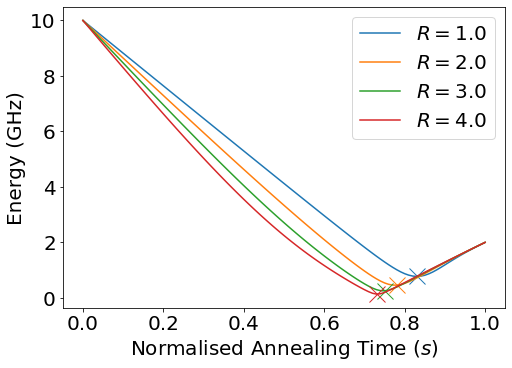

In [26]:
# Plot gap against time
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(7,5))
#ax1 = ax[0]
#ax2 = ax[1]
ax1=ax
times = np.linspace(0,tan,101)
# Instantaneous gap against anneal
for i,R in enumerate(Rvals):
    ax1.plot(times/tan, Egaps[R]/(2*np.pi),"-C%i"%i, label="$R=%.1f$"%R)
    ax1.plot(mingapspos[R],Egapsmin[R]/(2*np.pi),"xC%i"%i,markersize=16)
ax1.set_xlabel('Normalised Annealing Time ($s$)')
ax1.set_ylabel('Energy (GHz)')
ax1.legend()
fig.savefig("6-qubit-loop-gadget-spectrum-R.png")

In [27]:
mingapspos

{1.0: 0.83, 2.0: 0.7799999999999999, 3.0: 0.75, 4.0: 0.73}

In [33]:
# Range of annealing times
tf_min = 0.0
tf_max = 20.0
tf = np.linspace(tf_min,tf_max,101)

# 
l = loop_gadget(6,R=1,hx_init=1)
l.get_hp()

# Hamiltonian at t=0
tan = 100.0 # ns
p={"tan":tan,"stype":"linear"}
H0 = A(0,p)*l.Hd + B(0,p)*l.Hp

# Get the ground state at t=0 with eigenvalue E0,
# used as initial state in dynamics simulation
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
print ("Gap at t=0:\n %e GHz"%((Ei[1]-Ei[0])/(2*np.pi)))
#print (Ei)
psi0 = psi_i[0]

# Express results in terms of GS probability
E,states=l.Hp.eigenstates()

H = [[l.Hd,A],[l.Hp,B]]

# Use the Lindblad master equation solver
p0 = np.zeros(len(tf))
p1 = np.zeros(len(tf))
p2 = np.zeros(len(tf))
for i,tan in enumerate(tf):
    times = np.array([0,tan]) # Solve for final time only, initial time must be specified too
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    p={"tan":tan,"stype":"linear"}
    result = qt.mesolve(H, psi0, times, [], [], args=p, options=qt.Options(nsteps=1000000))
    
    # Save relevant results
    p0[i] = qt.expect(qt.ket2dm(result.states[-1]),states[0])
    p1[i] = qt.expect(qt.ket2dm(result.states[-1]),states[1])
    p2[i] = qt.expect(qt.ket2dm(result.states[-1]),states[2])

Gap at t=0:
 2.000000e+00 GHz


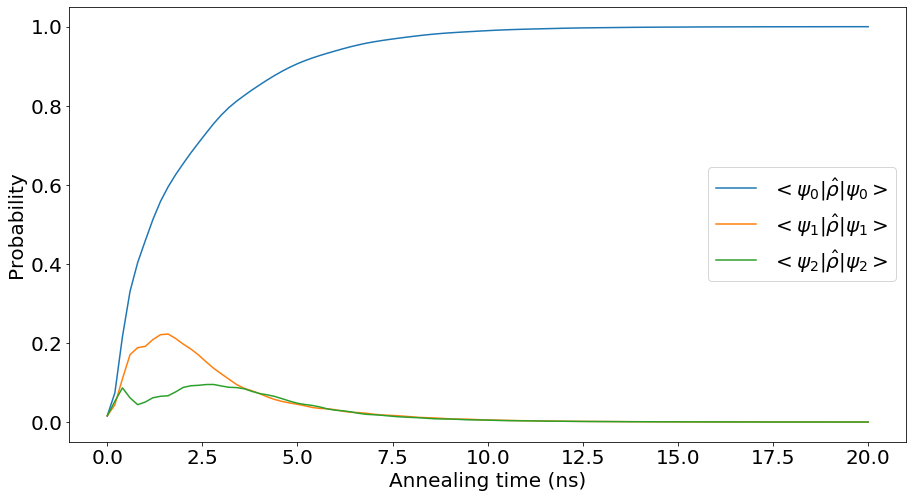

In [34]:
# Plot probabilities
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tf, p0, label="$<\psi_0|\hat{\\rho}|\psi_0>$")
ax.plot(tf, p1, label="$<\psi_1|\hat{\\rho}|\psi_1>$")
ax.plot(tf, p2, label="$<\psi_2|\hat{\\rho}|\psi_2>$")
#ax.plot(tf, B(s,p), label="$B(s)$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend()

In [5]:
# Schedules
def A(t,p):
    if p["stype"] == "linear":
        if t < 0:
            return 1.0
        elif t >= 0 and t <= p["tan"]:
            return (1.0-t/p["tan"])
        else:
            return 0.0
    elif p["stype"] == "interf":
        if t < 0:
            return 1.0
        elif t >= 0 and t/p["tan"] < p["smg"]+p["sw"]/2:
            return 1.0-t/p["tan"]
        elif t/p["tan"] >= p["smg"]+p["sw"]/2 and t/p["tan"] < p["smg"]+1.5*p["sw"]:
            return t/p["tan"]-(p["smg"]+p["sw"]/2)*2+1.0
        elif t/p["tan"] >= p["smg"]+1.5*p["sw"] and t/p["tan"] <= p["smg"]+1.5*p["sw"]+1-p["smg"]+p["sw"]/2:
            return -t/p["tan"] + (p["smg"]+1.5*p["sw"]+1-p["smg"]+p["sw"]/2)
        elif t/p["tan"] > p["smg"]+1.5*p["sw"]+1-p["smg"]+p["sw"]/2:
            return 0.0
def B(t,p):
    if p["stype"] == "linear":
        if t < 0:
            return 0.0
        elif t >= 0 and t <= p["tan"]:
            return (t/p["tan"])
        else:
            return 1.0
    elif p["stype"] == "interf":
        if t < 0:
            return 0.0
        elif t >= 0 and t/p["tan"] < p["smg"]+p["sw"]/2:
            return t/p["tan"]
        elif t/p["tan"] >= p["smg"]+p["sw"]/2 and t/p["tan"] < p["smg"]+1.5*p["sw"]:
            return -t/p["tan"]+(p["smg"]+p["sw"]/2)*2
        elif t/p["tan"] >= p["smg"]+1.5*p["sw"] and t/p["tan"] <= p["smg"]+1.5*p["sw"]+1-p["smg"]+p["sw"]/2:
            return 1+t/p["tan"] - (p["smg"]+1.5*p["sw"]+1-p["smg"]+p["sw"]/2)
        elif t/p["tan"] > p["smg"]+1.5*p["sw"]+1-p["smg"]+p["sw"]/2:
            return 1.0

In [81]:
# Find the minimum gap position
smg = tf[np.argmin(Egaps[3][:,1])]/tan

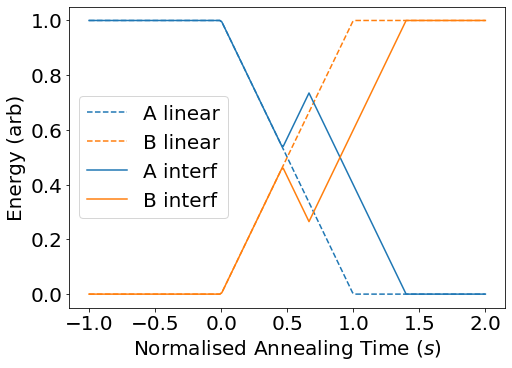

In [146]:
# Plot gap against time
tan =30.0
times = np.linspace(-tan,2*tan,201)
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(7,5))
p={"tan":tan,"stype":"linear"}
ax.plot(times/tan, [A(t,p) for t in times],"C0--", label="A linear")
ax.plot(times/tan, [B(t,p) for t in times],"C1--", label="B linear")
p={"tan":tan,"stype":"interf","smg":smg,"sw":0.2}
ax.plot(times/tan, [A(t,p) for t in times],"C0-", label="A interf")
ax.plot(times/tan, [B(t,p) for t in times],"C1-", label="B interf")
ax.set_xlabel('Normalised Annealing Time ($s$)')
ax.set_ylabel('Energy (arb)')
ax.legend()
fig.savefig("6-qubit-loop-gadget-schedules.png")

In [145]:
tan = 30.0 # ns
times = np.linspace(0,tan*1.5,101)
Egaps = {}
Rvals = [1.0,2.0,3.0,4.0]
for R in Rvals:
    p={"tan":tan,"stype":"interf","smg":mingapspos[R],"sw":0.2}
    l = loop_gadget(6,R=R)
    l.get_hp()
    
    # Get the energy gap as a function of time
    E0 = [0]*101
    for i,t in enumerate(times):
        H0 = A(t,p)*l.Hd + B(t,p)*l.Hp
        Ei = H0.eigenenergies()
        E0[i] = Ei[1]-Ei[0]
    Egaps[R] = np.array(E0)
    

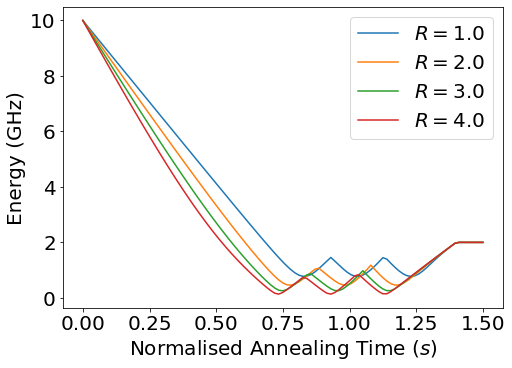

In [147]:
# Plot gap against time
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(7,5))
#ax1 = ax[0]
#ax2 = ax[1]
ax1=ax
times = np.linspace(0,1.5*tan,101)
# Instantaneous gap against anneal
for i,R in enumerate(Rvals):
    ax1.plot(times/tan, Egaps[R]/(2*np.pi),"-C%i"%i, label="$R=%.1f$"%R)
ax1.set_xlabel('Normalised Annealing Time ($s$)')
ax1.set_ylabel('Energy (GHz)')
ax1.legend()
fig.savefig("6-qubit-loop-gadget-interf-spectrum-R.png")

In [86]:
# Range of annealing times
tf_min = 0.0
tf_max = 150.0
tf = np.linspace(tf_min,tf_max,201)

# 
l = loop_gadget(6,R=4)
l.get_hp()

# Find the minimum gap position
smg = tf[np.argmin(Egaps[3][:,1])]/tan

# Hamiltonian at t=0
tan = 100.0 # ns
#p={"tan":tan,"stype":"linear"}
p={"tan":tan,"stype":"interf","smg":smg,"sw":0.4}
H0 = A(0,p)*l.Hd + B(0,p)*l.Hp

# Get the ground state at t=0 with eigenvalue E0,
# used as initial state in dynamics simulation
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
print ("Gap at t=0:\n %e GHz"%((Ei[1]-Ei[0])/(2*np.pi)))
#print (Ei)
psi0 = psi_i[0]

# Express results in terms of GS probability
E,states=l.Hp.eigenstates()

H = [[l.Hd,A],[l.Hp,B]]

# Use the Lindblad master equation solver
p0 = np.zeros(len(tf))
p1 = np.zeros(len(tf))
p2 = np.zeros(len(tf))
for i,tan in enumerate(tf):
    times = np.array([0,tan*(p["smg"]+1.5*p["sw"]+1-p["smg"]+p["sw"]/2)]) # Solve for final time only, initial time must be specified too
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    #p={"tan":tan,"stype":"linear"}
    p={"tan":tan,"stype":"interf","smg":smg,"sw":0.2}
    result = qt.mesolve(H, psi0, times, [], [], args=p, options=qt.Options(nsteps=1000000))
    
    # Save relevant results
    p0[i] = qt.expect(qt.ket2dm(result.states[-1]),states[0])
    p1[i] = qt.expect(qt.ket2dm(result.states[-1]),states[1])
    p2[i] = qt.expect(qt.ket2dm(result.states[-1]),states[2])

Gap at t=0:
 1.000000e+01 GHz


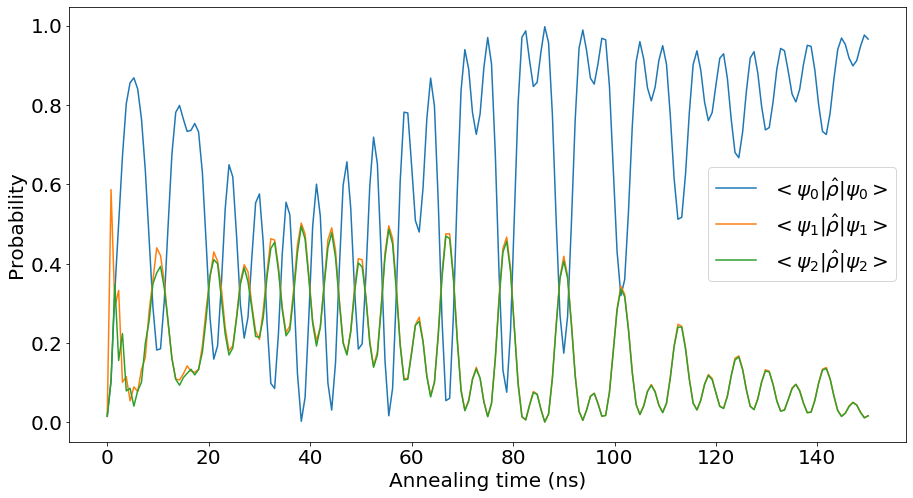

In [85]:
# Plot probabilities
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tf, p0, label="$<\psi_0|\hat{\\rho}|\psi_0>$")
ax.plot(tf, p1, label="$<\psi_1|\hat{\\rho}|\psi_1>$")
ax.plot(tf, p2, label="$<\psi_2|\hat{\\rho}|\psi_2>$")
#ax.plot(tf, B(s,p), label="$B(s)$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend()

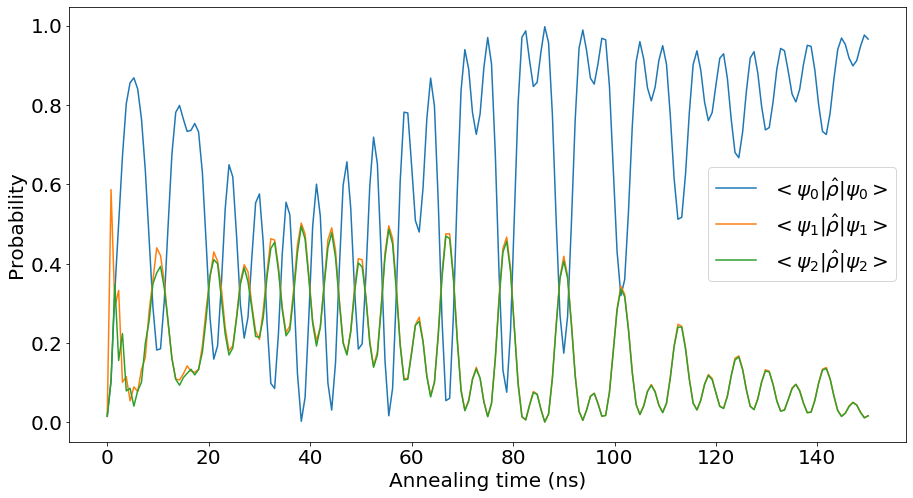

In [87]:
# Plot probabilities
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tf, p0, label="$<\psi_0|\hat{\\rho}|\psi_0>$")
ax.plot(tf, p1, label="$<\psi_1|\hat{\\rho}|\psi_1>$")
ax.plot(tf, p2, label="$<\psi_2|\hat{\\rho}|\psi_2>$")
#ax.plot(tf, B(s,p), label="$B(s)$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend()

### Notes

* Need a schedule that rapidly propagates the phase of the excited states.
* Need a schedule that ensure the excited state amplitude is large.

Repeat the above as a function of bias strength $R$:

In [115]:
# Range of annealing times
tf_min = 0.0
tf_max = 150.0
tf = np.linspace(tf_min,tf_max,101)

p0reslin = {}
p1reslin = {}
p2reslin = {}
for R in Rvals:
    # 
    l = loop_gadget(6,R=R)
    l.get_hp()

    # Hamiltonian at t=0
    tan = 100.0 # ns
    p={"tan":tan,"stype":"linear"}
    H0 = A(0,p)*l.Hd + B(0,p)*l.Hp

    # Get the ground state at t=0 with eigenvalue E0,
    # used as initial state in dynamics simulation
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    print ("Gap at t=0:\n %e GHz"%((Ei[1]-Ei[0])/(2*np.pi)))
    #print (Ei)
    psi0 = psi_i[0]

    # Express results in terms of GS probability
    E,states=l.Hp.eigenstates()

    H = [[l.Hd,A],[l.Hp,B]]

    # Use the Lindblad master equation solver
    p0 = np.zeros(len(tf))
    p1 = np.zeros(len(tf))
    p2 = np.zeros(len(tf))
    for i,tan in enumerate(tf):
        times = np.array([0,tan]) # Solve for final time only, initial time must be specified too

        # Use time dependent Hamiltonian and specify initial state
        # Unitary evolution: No dissipation. qt.sigmaz()
        p={"tan":tan,"stype":"linear"}
        result = qt.mesolve(H, psi0, times, [], [], args=p, options=qt.Options(nsteps=1000000))

        # Save relevant results
        p0[i] = qt.expect(qt.ket2dm(result.states[-1]),states[0])
        p1[i] = qt.expect(qt.ket2dm(result.states[-1]),states[1])
        p2[i] = qt.expect(qt.ket2dm(result.states[-1]),states[2])
    p0reslin[R] = p0
    p1reslin[R] = p1
    p2reslin[R] = p2

Gap at t=0:
 1.000000e+01 GHz
Gap at t=0:
 1.000000e+01 GHz
Gap at t=0:
 1.000000e+01 GHz
Gap at t=0:
 1.000000e+01 GHz


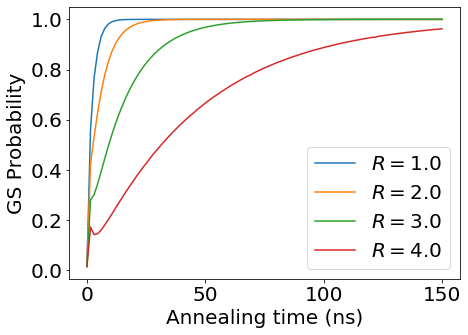

In [148]:
tf_min = 0.0
tf_max = 150.0
tf = np.linspace(tf_min,tf_max,101)
# Plot probabilities
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
for R in Rvals:
    ax.plot(tf, p0reslin[R], label="$R=%.1f$"%R)
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('GS Probability')
ax.legend()
fig.savefig("6-qubit-loop-gadget-GS-result.png")

In [131]:
# Range of annealing times
tf_min = 0.0
tf_max = 150.0
tf = np.linspace(tf_min,tf_max,1001)

p0res = {}
p1res = {}
p2res = {}
for j,R in enumerate(Rvals):
    # 
    l = loop_gadget(6,R=R)
    l.get_hp()

    # Hamiltonian at t=0
    tan = 100.0 # ns
    #p={"tan":tan,"stype":"linear"}
    p={"tan":tan,"stype":"interf","smg":mingapspos[R],"sw":0.2}
    H0 = A(0,p)*l.Hd + B(0,p)*l.Hp

    # Get the ground state at t=0 with eigenvalue E0,
    # used as initial state in dynamics simulation
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    print ("Gap at t=0:\n %e GHz"%((Ei[1]-Ei[0])/(2*np.pi)))
    #print (Ei)
    psi0 = psi_i[0]

    # Express results in terms of GS probability
    E,states=l.Hp.eigenstates()

    H = [[l.Hd,A],[l.Hp,B]]

    # Use the Lindblad master equation solver
    p0 = np.zeros(len(tf))
    p1 = np.zeros(len(tf))
    p2 = np.zeros(len(tf))
    for i,tan in enumerate(tf):
        times = np.array([0,tan*(p["smg"]+1.5*p["sw"]+1-p["smg"]+p["sw"]/2)]) # Solve for final time only, initial time must be specified too

        # Use time dependent Hamiltonian and specify initial state
        # Unitary evolution: No dissipation. qt.sigmaz()
        #p={"tan":tan,"stype":"linear"}
        p={"tan":tan,"stype":"interf","smg":mingapspos[R],"sw":0.2}
        result = qt.mesolve(H, psi0, times, [], [], args=p, options=qt.Options(nsteps=1000000))

        # Save relevant results
        p0[i] = qt.expect(qt.ket2dm(result.states[-1]),states[0])
        p1[i] = qt.expect(qt.ket2dm(result.states[-1]),states[1])
        p2[i] = qt.expect(qt.ket2dm(result.states[-1]),states[2])
    p0res[R] = p0
    p1res[R] = p1
    p2res[R] = p2
    

Gap at t=0:
 1.000000e+01 GHz
Gap at t=0:
 1.000000e+01 GHz
Gap at t=0:
 1.000000e+01 GHz
Gap at t=0:
 1.000000e+01 GHz


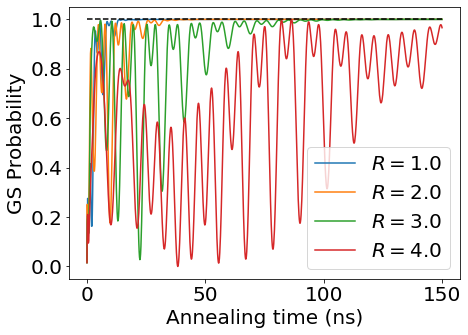

In [149]:
tf_min = 0.0
tf_max = 150.0
tf = np.linspace(tf_min,tf_max,1001)
# Plot probabilities
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
for R in Rvals:
    ax.plot(tf, p0res[R], label="$R=%.1f$"%R)
ax.plot([tf[0],tf[-1]],[1,1],"--k")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('GS Probability')
ax.legend()
fig.savefig("6-qubit-loop-gadget-interf-GS-result.png")

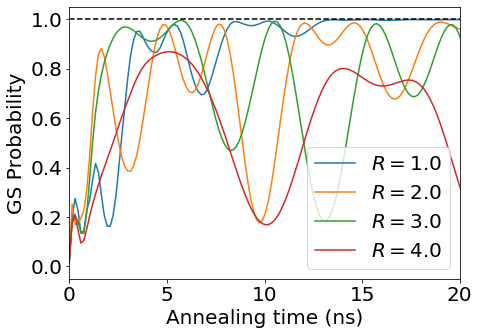

In [150]:
tf_min = 0.0
tf_max = 150.0
tf = np.linspace(tf_min,tf_max,1001)
# Plot probabilities
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
for R in Rvals:
    ax.plot(tf, p0res[R], label="$R=%.1f$"%R)
ax.plot([tf[0],tf[-1]],[1,1],"--k")
ax.set_xlim((0,20))
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('GS Probability')
ax.legend()
fig.savefig("6-qubit-loop-gadget-interf-GS-result-zoom.png")

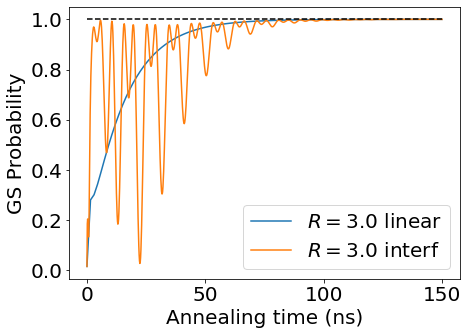

In [151]:
tf_min = 0.0
tf_max = 150.0
tf2 = np.linspace(tf_min,tf_max,1001)
tf1 = np.linspace(tf_min,tf_max,101)
R=3.0
# Plot probabilities
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.plot(tf1, p0reslin[R], label="$R=%.1f$ linear"%R)
ax.plot(tf2, p0res[R], label="$R=%.1f$ interf"%R)
ax.plot([tf[0],tf[-1]],[1,1],"--k")
#ax.set_xlim((0,20))
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('GS Probability')
ax.legend()
fig.savefig("6-qubit-loop-gadget-R=3-comparison.png")

# Let's try with sinusoidal schedules

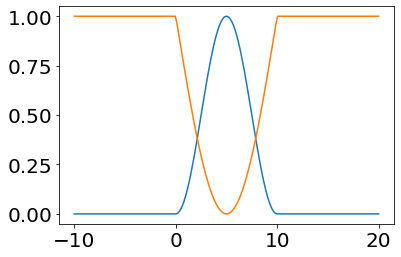

In [20]:
# Sinusoidal schedules
def phi_x_sig(t,p):
    if t < 0:
        return p["x_min"]
    elif t >= 0 and t <= p["tan"]:
        return (p["x_max"] - p["x_min"])*np.sin(t/p["tan"]*np.pi)**2 + p["x_min"]
    else:
        return p["x_min"]

def phi_z_sig(t,p):
    if t < 0:
        return p["z_max"]
    elif t >= 0 and t <= p["tan"]:
        return p["z_max"]*(1-np.sin(t/p["tan"]*np.pi))
    else:
        return p["z_max"]

tan = 10
p = {"tan":tan,"x_max":1.0,"x_min":0.0,"z_max":1.0}
times = np.linspace(-tan,2*tan,200)
phi_x_p = np.array([phi_x_sig(t,p) for t in times])
phi_z_p = np.array([phi_z_sig(t,p) for t in times])

plt.plot(times,phi_x_p)
plt.plot(times,phi_z_p)

In [37]:
tan = 30.0 # ns
times = np.linspace(0.0,tan,101)
Egaps = {}
Rvals = [1.0,2.0,3.0,4.0]
for R in Rvals:
    p = {"tan":tan,"x_max":1.0,"x_min":0.0,"z_max":1.0}
    l = loop_gadget(6,R=R,hx_init=1)
    l.get_hp()
    
    # Get the energy gap as a function of time
    E0 = [0]*101
    for i,t in enumerate(times):
        H0 = phi_x_sig(t,p)*l.Hd + phi_z_sig(t,p)*l.Hp
        Ei = H0.eigenenergies()
        E0[i] = Ei[1]-Ei[0]
    Egaps[R] = np.array(E0)
    

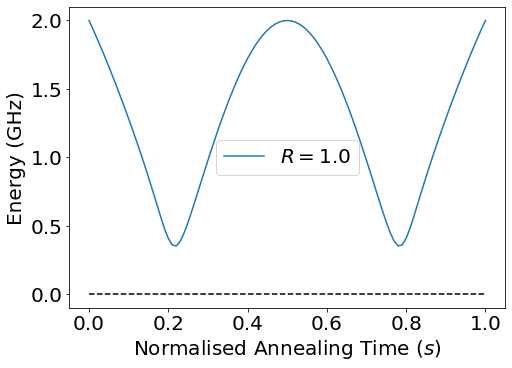

In [38]:
# Plot gap against time
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(7,5))
#ax1 = ax[0]
#ax2 = ax[1]
ax1=ax
times = np.linspace(0,tan,101)
# Instantaneous gap against anneal
for i,R in enumerate([1]):
    ax1.plot(times/tan, Egaps[R]/(2*np.pi),"-C%i"%i, label="$R=%.1f$"%R)
ax1.plot([0,1],[0,0],"k--")
ax1.set_xlabel('Normalised Annealing Time ($s$)')
ax1.set_ylabel('Energy (GHz)')
ax1.legend()
#fig.savefig("6-qubit-loop-gadget-interf-spectrum-R.png")

In [30]:
# Range of annealing times
tf_min = 0.0
tf_max = 20.0
tfs = np.linspace(tf_min,tf_max,401)

# 
l = loop_gadget(6,R=1,hx_init=1)
l.get_hp()

# Hamiltonian at t=0
tan = 100.0 # ns
p = {"tan":tan,"x_max":1.0,"x_min":0.0,"z_max":1.0}
H0 = phi_x_sig(0,p)*l.Hd + phi_z_sig(0,p)*l.Hp

# Get the ground state at t=0 with eigenvalue E0,
# used as initial state in dynamics simulation
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
print ("Gap at t=0:\n %e GHz"%((Ei[1]-Ei[0])/(2*np.pi)))
#print (Ei)
psi0 = psi_i[0]

# Express results in terms of GS probability
E,states=l.Hp.eigenstates()

H = [[l.Hd,phi_x_sig],[l.Hp,phi_z_sig]]

# Use the Lindblad master equation solver
p0s = np.zeros(len(tfs))
p1s = np.zeros(len(tfs))
p2s = np.zeros(len(tfs))
for i,tan in enumerate(tfs):
    times = np.array([0,tan]) # Solve for final time only, initial time must be specified too
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    p = {"tan":tan,"x_max":1.0,"x_min":0.0,"z_max":1.0}
    result = qt.mesolve(H, psi0, times, [], [], args=p, options=qt.Options(nsteps=1000000))
    
    # Save relevant results
    p0s[i] = qt.expect(qt.ket2dm(result.states[-1]),states[0])
    p1s[i] = qt.expect(qt.ket2dm(result.states[-1]),states[1])
    p2s[i] = qt.expect(qt.ket2dm(result.states[-1]),states[2])

Gap at t=0:
 2.000000e+00 GHz


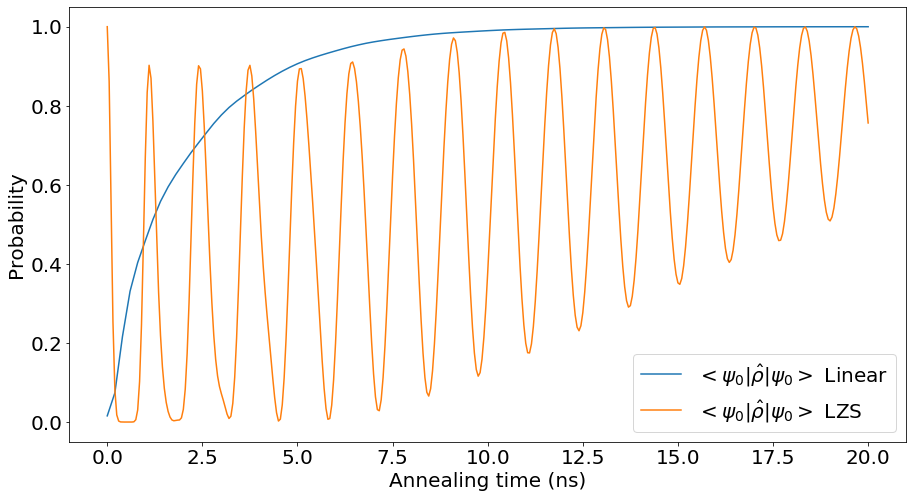

In [35]:
# Plot probabilities
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tf, p0, label="$<\psi_0|\hat{\\rho}|\psi_0>$ Linear")
ax.plot(tfs, p0s, label="$<\psi_0|\hat{\\rho}|\psi_0>$ LZS")
#ax.plot(tf, p1, label="$<\psi_1|\hat{\\rho}|\psi_1>$")
#ax.plot(tf, p2, label="$<\psi_2|\hat{\\rho}|\psi_2>$")
#ax.plot(tf, B(s,p), label="$B(s)$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend()

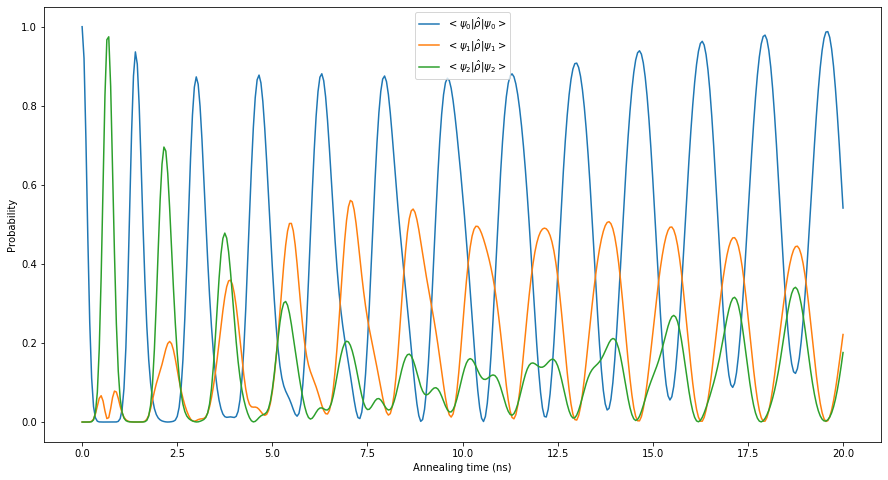

In [13]:
# Plot probabilities
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tf, p0, label="$<\psi_0|\hat{\\rho}|\psi_0>$")
ax.plot(tf, p1, label="$<\psi_1|\hat{\\rho}|\psi_1>$")
ax.plot(tf, p2, label="$<\psi_2|\hat{\\rho}|\psi_2>$")
#ax.plot(tf, B(s,p), label="$B(s)$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend()